In [2]:
%reset
# import libraries & modules
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


C:\Users\dell pc\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Path of the file to read
titanic_file_path = "C:/Users/dell pc/Downloads/open_data/titanicsurvival/train.csv"
test_data_path = "C:/Users/dell pc/Downloads/open_data/titanicsurvival/test.csv"

# read test data file
titanic_data = pd.read_csv(titanic_file_path)
test_data = pd.read_csv(test_data_path)

# Drop sample where the target is missing
titanic_data.dropna(axis=0, subset=['Survived'], inplace=True) # 'Survived' is the target

In [105]:
# check whether passenger have cabin or not. make new variable 'HaveCabin'
titanic_data['HaveCabin'] = titanic_data.Cabin.apply(lambda havecab: 0 if type(havecab)==float else 1)
test_data['HaveCabin'] = test_data.Cabin.apply(lambda havecab: 0 if type(havecab)==float else 1)

In [4]:
# Create target object 'y'
y = titanic_data.Survived

# drop column with too many NaN: drop column with >25% NaN
col_with_many_na = [col for col in titanic_data.columns if titanic_data[col].isnull().sum() > len(titanic_data)*0.25]
# drop target and irrelevant column (too many NaN, PassengerID, etc):
X = titanic_data.drop(['PassengerId','Survived'] + col_with_many_na, axis=1)#.select_dtypes(exclude=['object'])
X_test = test_data.drop(['PassengerId'] + col_with_many_na, axis=1)#.select_dtypes(exclude=['object'])

In [107]:
# One-hot encoding for categorical data
# "cardinality" means the number of unique values in a column.
# We use it as our only way to select categorical columns here.
# One-hot encoding generally doesn't work well with categorical variable value >15
low_cardinality_cols = [cname for cname in X.columns if 
                                X[cname].nunique() < 10 and 
                                X[cname].dtype == "object"]
numeric_cols = [cname for cname in X.columns if
                                X[cname].dtype in ['int64', 'float64']]
                
my_cols = low_cardinality_cols + numeric_cols
X_for_ohe = X[my_cols]
X_test_for_ohe = X_test[my_cols]

# One-hot encoding 'ohe'
X_ohe = pd.get_dummies(X_for_ohe)
X_test_ohe = pd.get_dummies(X_test_for_ohe)


final_X_ohe, final_X_test_ohe = X_ohe.align(X_test_ohe,
                                                join='left', 
                                                axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017DEC9FF2E8>]],
      dtype=object)

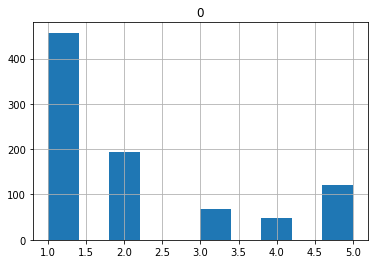

In [121]:
# Set number of bin for the most important variable for splitting train and test dataset
bins     = np.linspace(0, 60, 5)
Fare_binned = np.digitize(final_X_ohe.Fare, bins)

# print(Fare_binned)
pd.DataFrame(Fare_binned).hist()

In [123]:
# split data X into train and validation data
X_train, X_val, y_train, y_val = train_test_split(final_X_ohe, 
                                                    y,
                                                    test_size = 0.25,
                                                    stratify=Fare_binned,
                                                    random_state=1)

# to do list:
# take out outlie sample
# make attribute plots

# Create Function to Measure Quality of An Approach
def score_dataset(X_train, X_val, y_train, y_val):
    model = XGBRegressor(n_estimators=1000, random_state=1)
    model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_val, y_val)], verbose=False)
    preds = model.predict(X_val)
    
    idx = pd.DataFrame(preds).index
    y_val_reidx = pd.DataFrame(y_val).set_index(idx)
  
    return ((y_val_reidx['Survived'] == pd.DataFrame(preds).round()[0]).sum())/len(y_val)

In [124]:
# Get Score from Imputation with Extra Columns Showing What Was Imputed
imputed_X_train_plus = X_train.copy()
imputed_X_val_plus = X_val.copy()
imputed_X_plus = final_X_test_ohe.copy()
imputed_X_valntrain_full = final_X_ohe.copy()

cols_with_missing = [col for col in X_train.columns 
                                 if X_train[col].isnull().any()]
for col in cols_with_missing:
    imputed_X_train_plus[col + '_was_missing'] = imputed_X_train_plus[col].isnull()
    imputed_X_val_plus[col + '_was_missing'] = imputed_X_val_plus[col].isnull()
    imputed_X_plus[col + '_was_missing'] = imputed_X_plus[col].isnull()
    imputed_X_valntrain_full[col + '_was_missing'] = imputed_X_valntrain_full[col].isnull()

In [125]:
#  Apply Imputation, fill missing values
my_imputer = Imputer()
imputed_X_train_plus = my_imputer.fit_transform(imputed_X_train_plus)
imputed_X_val_plus = my_imputer.transform(imputed_X_val_plus)
imputed_X_plus = my_imputer.transform(imputed_X_plus)
imputed_X_valntrain_full = my_imputer.transform(imputed_X_valntrain_full)

accuracy_impute_tracker = score_dataset(imputed_X_train_plus, imputed_X_val_plus, y_train, y_val)
print("Accuracy percentage from Imputation while Track What Was Imputed:{:,.3%} ".format(accuracy_impute_tracker))

Accuracy percentage from Imputation while Track What Was Imputed:85.202% 


In [126]:
# XGBoost model
# set n_estimator for how many cycle prediction, too low-too high = under-overfit
xgb_model = XGBRegressor(n_estimators=1000, random_state=1) #option: learning_rate=0.05
# Add silent=True to avoid printing out updates with each cycle

# set early_stopping_round for how many deteriorating validation before stopping the cycle
# (automatically choose appropriate number of trees)
xgb_model.fit(imputed_X_train_plus, y_train, early_stopping_rounds=5, 
             eval_set=[(imputed_X_val_plus, y_val)], verbose=False)

# Make validation predictions and calculate mean absolute error
xgb_val_predictions = xgb_model.predict(imputed_X_val_plus)

idx = pd.DataFrame(xgb_val_predictions).index
y_val_reidx = pd.DataFrame(y_val).set_index(idx)
  
accuracy_xgboost = ((y_val_reidx['Survived'] == pd.DataFrame(xgb_val_predictions).round()[0]).sum())/len(y_val)

print("Accuracy percentage from XGBoost model:{:,.3%} ".format(accuracy_xgboost))


Accuracy percentage from XGBoost model:85.202% 


In [72]:
# pd.DataFrame(xgb_val_predictions).head()
# X_train.head()

In [127]:
# Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=1)

gb_model.fit(imputed_X_train_plus, y_train)

# Make validation predictions and calculate mean absolute error
gb_val_predictions = gb_model.predict(imputed_X_val_plus)

idx = pd.DataFrame(gb_val_predictions).index
y_val_reidx = pd.DataFrame(y_val).set_index(idx)
  
accuracy_gb = ((y_val_reidx['Survived'] == pd.DataFrame(gb_val_predictions).round()[0]).sum())/len(y_val)

print("Accuracy for base gradient boosting model: {:,.3%}".format(accuracy_gb))

Accuracy for base gradient boosting model: 85.202%


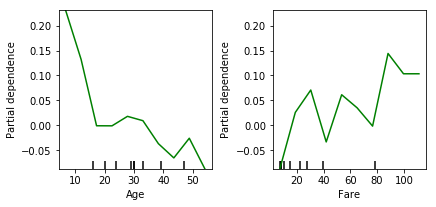

In [80]:
# partial dependence plot
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

pdplots = plot_partial_dependence(gb_model,       
                                   features=[list(X_train.columns).index('Age'),
                                             list(X_train.columns).index('Fare')], # column numbers of plots we want to show
                                   X=imputed_X_train_plus,        # raw predictors data.
                                   feature_names=list(X_train.columns), # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis

In [128]:
# Pipelines
# input for pipelines is pre-processed dataset just prior to imputation. So don't apply imputation before running this.
thepipe = make_pipeline(Imputer(), XGBRegressor(n_estimators=1000, random_state=1))

thepipe.fit(imputed_X_train_plus, y_train)
thepipe_pred = thepipe.predict(imputed_X_val_plus)

# Make validation predictions and calculate mean absolute error
idx = pd.DataFrame(thepipe_pred).index
y_val_reidx = pd.DataFrame(y_val).set_index(idx)
  
accuracy_pipeline = ((y_val_reidx['Survived'] == pd.DataFrame(thepipe_pred).round()[0]).sum())/len(y_val)

print("Accuracy for base gradient boosting model: {:,.3%}".format(accuracy_pipeline))


Accuracy for base gradient boosting model: 85.202%


In [65]:
# Cross-validation for num3rical target
#  just as the 'pipelines' cell,
# input for pipelines is pre-processed dataset just prior to imputation. So don't apply imputation before running this.
# scores_crossval = cross_val_score(thepipe, imputed_X_valntrain_full, y, scoring='accuracy') # option: scoring='accuracy'
# print(scores_crossval)
# print('Mean Accuracy' %(-1 * scores_crossval.mean()))


In [123]:
# Creating model and output for competition
# To improve accuracy, create a new Random Forest model to train on all training data
xgb_model_on_full_data = XGBRegressor(n_estimators=1000, random_state=1)

# fit rf_model_on_full_data on all data from the 
xgb_model_on_full_data.fit(imputed_X_valntrain_full, y, verbose=False)

# make predictions which we will submit. 
test_preds = xgb_model_on_full_data.predict(imputed_X_plus)
test_preds = pd.DataFrame(test_preds).round()[0]
test_preds = test_preds.astype(np.int64)

# The lines below shows how to save your data in the format needed to store it in the competition
output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Survived': test_preds})

output.to_csv("C:/Users/dell pc/Downloads/open_data/titanicsurvival/submission.csv", index=False)

print("Done")

Done


In [125]:
# check the submission
submission_path = "C:/Users/dell pc/Downloads/open_data/titanicsurvival/submission.csv"

# read submission data file using pandas
submission_data = pd.read_csv(submission_path)

print(submission_data.head())
print(gendersubmission_data.head())


   PassengerId  Survived
0          892         0
1          893         0
2          894         1
3          895         0
4          896         1
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
